In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillage/'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    """
    Loads an image from the specified path, resizes it to the default image size, 
    and converts it to a NumPy array suitable for model input.

    Parameters:
    image_dir (str): Path to the image file.

    Returns:
    numpy.ndarray: Array representation of the image, or an empty array if the image is invalid,
                   or None if an exception occurs.
    """
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
50/50 [==============================] - 27s 544ms/step - loss: 0.2929 - acc: 0.9066 - val_loss: 0.2728 - val_acc: 0.9227
Epoch 2/25
50/50 [==============================] - 22s 442ms/step - loss: 0.2140 - acc: 0.9279 - val_loss: 0.7363 - val_acc: 0.8725
Epoch 3/25
50/50 [==============================] - 23s 454ms/step - loss: 0.1878 - acc: 0.9356 - val_loss: 1.4424 - val_acc: 0.8540
Epoch 4/25
50/50 [==============================] - 22s 435ms/step - loss: 0.1641 - acc: 0.9417 - val_loss: 0.7191 - val_acc: 0.8930
Epoch 5/25
50/50 [==============================] - 22s 441ms/step - loss: 0.1373 - acc: 0.9512 - val_loss: 1.5633 - val_acc: 0.8478
Epoch 6/25
50/50 [==============================] - 22s 443ms/step - loss: 0.1237 - acc: 0.9558 - val_loss: 0.3107 - val_acc: 0.9228
Epoch 7/25
50/50 [==============================] - 22s 436ms/step - loss: 0.1210 - acc: 0.9557 - val_loss: 0.2629 - val_acc: 0.9352
Epoch 8/25
50/50 [===

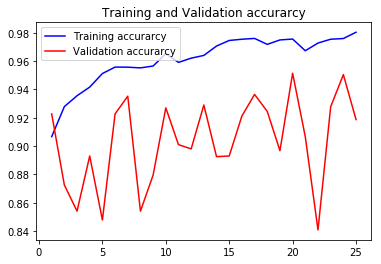

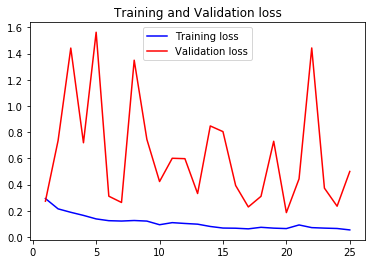

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
400/400 [==============================] - 1s 2ms/step
Test Accuracy: 91.87499761581421
